### Постановка задачи и датасет

В качестве датасета используются вопросы и ответы с медицинских форумов. Предполагается, что чат-бот будет давать какие-то советы, которые соотносятся с жалобами людей на здоровье.

### Импорт библиотек и данных

In [1]:
import math
import numpy as np
import pandas as pd

import random
import json
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import time

from tqdm import tqdm

from matplotlib import pyplot as plt

import youtokentome as yttm

import os

In [2]:
qa_data = pd.read_csv('medical_qa_ru_data.csv',).rename(columns={'desc': 'question', 'ans': 'answer'})

In [3]:
qa_data.head()

,date,categ,theme,question,answer,spec10
0,"8 Октября 2017, 11:55",Оториноларингология,Применение Ларипронта.,"Ларипронт 20 талеток,через каждые 2-3 часа.Оче...",Что вы им лечите? Длительность приема Ларипрон...,Отоларинголог
1,"20 Февраля 2019, 13:24",Акушерство,Беременность,"Здравствуйте, я на 7-8 неделе беременности. С ...","Здравствуйте, это может быть признаком раннего...",NaN
2,"17 Марта 2015, 18:31",Другое,гинекология,Здравствуйте месячные должны придти 23 марта в...,Выполните исследование хгч,NaN
3,"13 Января 2019, 19:38",Терапия,Занятия спорта после сдачи крови,"Завтра иду с утра сдавать кровь ТТГ, Т4СВ, Кал...","Можно.;\nЗдравствуйте , да, попейте сладкого ч...",Терапевт
4,"28 Ноября 2017, 21:58",Другое,Таблетки,Мне прописали пить Аллохол. Врач написала пить...,Препарат принимается после еды. Уточните это ...,NaN


### Фильтрация данных

In [4]:
qa_data = qa_data.drop_duplicates(subset=['question', 'answer'])

<AxesSubplot: ylabel='Frequency'>

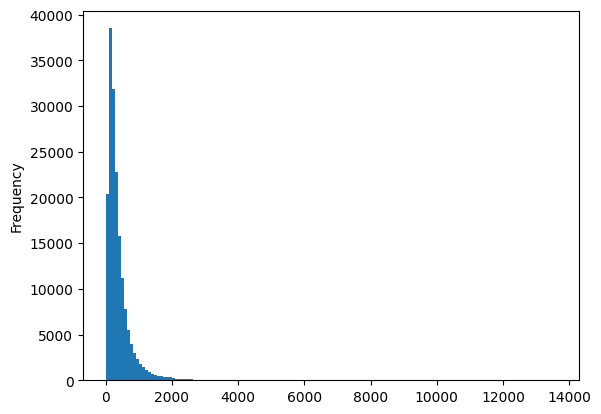

In [7]:
qa_data['question'].str.len().plot.hist(bins=150)

<AxesSubplot: ylabel='Frequency'>

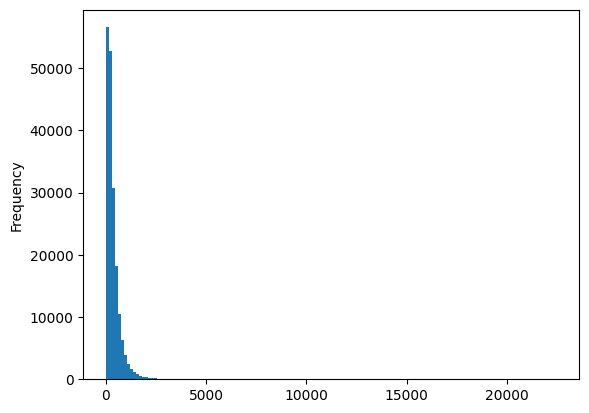

In [8]:
qa_data['answer'].str.len().plot.hist(bins=150)

In [5]:
qa_data = qa_data[(qa_data['question'].str.len() >= 150) & (qa_data['answer'].str.len() >= 150)]

### Обучение токенайзера

In [6]:
model_path = 'pretrained_bpe_lm_med.model'

In [7]:
if not os.path.isfile(model_path):
    with open('for_bpe.txt', 'w', encoding='utf-8') as f:
        for que in qa_data['question']:
            f.write(que + '\n')

    # параметры
    vocab_size = 30_000
    yttm.BPE.train(data='for_bpe.txt', vocab_size=vocab_size, model=model_path, )

tokenizer = yttm.BPE(model=model_path)

### Написание классов для обработки датасета

In [8]:
class Seq2SeqDataset(torch.utils.data.Dataset):
    
    def __init__(self, data):
        super().__init__()
        assert type(data) == pd.DataFrame, f'Data is not {pd.DataFrame.__name__}'
        assert all(column in data.columns for column in ['question', 'answer']), \
                'Data does not contain question or/and answer columns'
        self.data = list(zip(data['question'], data['answer']))
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        question, answer = self.data[index]
        
        return {'question': question, 'answer': answer}

In [9]:
class Collator:
    
    def __init__(self, 
                 base_tokenizer, 
                 pad_token,
                 pad_index,
                 max_len=64, 
                 base_tokenizer_args=None,):
        assert  hasattr(base_tokenizer, 'encode'), 'The tokenizer does not have an encode method'
        
        self._base_tokenizer = base_tokenizer
        self._base_tokenizer_args = base_tokenizer_args
        
        self.pad_token = pad_token
        self.pad_index = pad_index
        
        self.max_len = max_len
        
    def collate(self, batch):
        questions = [sample['question'] for sample in batch]
        answers = [sample['answer'] for sample in batch]
        
        questions = self._base_tokenizer.encode(questions, **self._base_tokenizer_args['question'])
        answers = self._base_tokenizer.encode(answers, **self._base_tokenizer_args['answer'])
        
        questions = [question[:self.max_len] + [self.pad_index] * (self.max_len - len(question)) for question in questions]
        answers = [answer[:self.max_len] + [self.pad_index] * (self.max_len - len(answer)) for answer in answers]
            
        questions = torch.tensor(questions).long()
        answers = torch.tensor(answers).long()
        
        return questions, answers

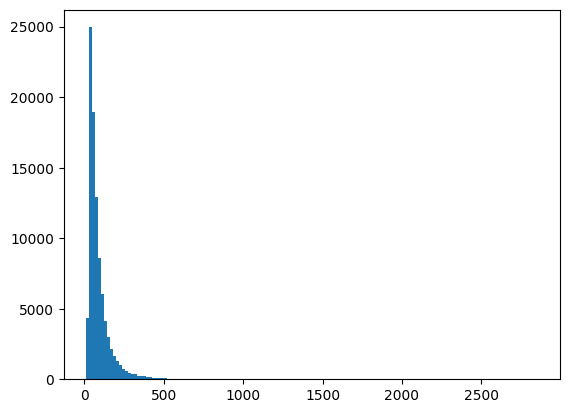

In [12]:
plt.hist([len(tokens) for tokens in tokenizer.encode(qa_data['question'].tolist())], bins=150)
plt.show()

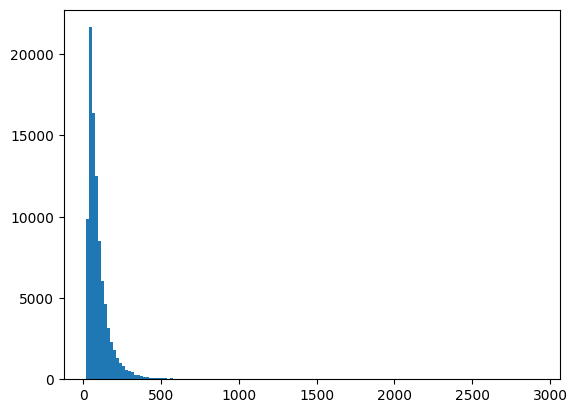

In [15]:
plt.hist([len(tokens) for tokens in tokenizer.encode(qa_data['answer'].tolist())], bins=150)
plt.show()

### Формирование данных для обучения

In [10]:
pairs = qa_data.sample(qa_data.shape[0] // 144 * 60).reset_index(drop=True)

train_dataset = Seq2SeqDataset(pairs[:int(len(pairs)*.9)])
validation_dataset = Seq2SeqDataset(pairs[int(len(pairs)*.9):])

len(train_dataset), len(validation_dataset)

(35046, 3894)

In [11]:
batch_size = 16

max_len = 256

pad_token = '<PAD>'
pad_index = tokenizer.subword_to_id(pad_token)

In [12]:
collator = Collator(tokenizer, pad_token, pad_index, max_len, {'question': {'bos': True, 'eos': True}, 
                                                               'answer': {'bos': True, 'eos': True}})

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, collate_fn = collator.collate)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, collate_fn = collator.collate)

### Написание классов для модели

In [13]:
class Encoder(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, 
                 hidden_size, num_layers, dropout, padding_idx):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        
        self.embeddings = torch.nn.Embedding(num_embeddings=vocab_size,
                                             embedding_dim=embedding_dim,
                                             padding_idx=padding_idx)
        self.lstm = torch.nn.LSTM(input_size=embedding_dim, 
                                  hidden_size=hidden_size, 
                                  num_layers=num_layers,
                                  dropout = dropout,
                                  batch_first=True, )
        self.dropout = torch.nn.Dropout(dropout)
        self.linear = torch.nn.Linear(in_features=hidden_size, 
                                      out_features=hidden_size)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        x, mem = self.lstm(x)
        x = self.linear(x)
        return x, mem

In [14]:
class Attention(torch.nn.Module):
    
    def __init__(self, hidden_size, max_len):
        super(Attention, self).__init__()
        
        self.attention_layer = torch.nn.Linear(in_features=hidden_size*2, out_features=max_len)
        self.softmax = torch.nn.Softmax(dim=-1)
    
    def forward(self, x, hidden):
        attention_weights = torch.cat((x, hidden[0].transpose(1, 0)), dim=-1)
        attention_weights = self.attention_layer(attention_weights)
        return self.softmax(attention_weights)

In [15]:
class Decoder(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, 
                 hidden_size, num_layers, dropout, 
                 padding_idx, attention_layer):
        super(Decoder, self).__init__()
        
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        
        self.embeddings = torch.nn.Embedding(num_embeddings=vocab_size,
                                             embedding_dim=embedding_dim,
                                             padding_idx=padding_idx)
        self.attention = attention_layer
        self.combine_layer = torch.nn.Linear(in_features=self.hidden_size*2, out_features=self.hidden_size)
        self.lstm = torch.nn.LSTM(input_size=embedding_dim, 
                                  hidden_size=hidden_size, 
                                  num_layers=num_layers, 
                                  dropout=dropout,
                                  batch_first=True)
        self.dropout = torch.nn.Dropout(dropout)
        self.linear = torch.nn.Linear(in_features=hidden_size, 
                                      out_features=vocab_size)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x, mem, encoder_outputs):
        emb = self.embeddings(x)
        emb = self.dropout(emb)
        weights = self.attention(emb, mem)
        x = torch.bmm(weights, encoder_outputs)
        x = torch.cat((emb, x), dim=-1)
        x = self.combine_layer(x)
        x = self.relu(x)
        x, mem = self.lstm(x, mem)
        x = self.linear(x)
        return x, mem, weights

In [16]:
class Seq2SeqModel(torch.nn.Module):
    
    def __init__(self, encoder, decoder, teacher_forcing=.5):
        super(Seq2SeqModel, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.teacher_forcing = teacher_forcing
        
    def forward(self, x, y):
        encoder_outputs, encoder_hidden = self.encoder(x)
        
        decoder_hidden = encoder_hidden
        decoder_input = y[:, 0].unsqueeze(1)
        
        decoder_outputs = [torch.zeros((x.size(0), 1, decoder.vocab_size)).long().to(device)]
        for i in range(1, y.size(1)):
            decoder_output, decoder_hidden, decoder_attention = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            teacher_force = random.random() < self.teacher_forcing
            decoder_input = y[:, i].unsqueeze(1) if teacher_force else decoder_output.argmax(-1)
            decoder_outputs.append(decoder_output)
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        return decoder_outputs

### Инициализация модели и начало обучения

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

VOCAB_SIZE = tokenizer.vocab_size()
MAX_LEN = max_len
EMBEDDING_DIM_ENCODER = 256
EMBEDDING_DIM_DECODER = 128
HIDDEN_SIZE = 128
NUM_LAYERS = 1
DROPOUT_ENCODER = .5
DROPOUT_DECODER = .5

attention = Attention(HIDDEN_SIZE, MAX_LEN)
encoder = Encoder(VOCAB_SIZE, EMBEDDING_DIM_ENCODER, HIDDEN_SIZE, 
                  NUM_LAYERS, DROPOUT_ENCODER, pad_index).to(device)
decoder = Decoder(VOCAB_SIZE, EMBEDDING_DIM_DECODER, HIDDEN_SIZE, 
                  NUM_LAYERS, DROPOUT_DECODER, pad_index, attention).to(device)
model = Seq2SeqModel(encoder, decoder)

criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_index)

optimizer = torch.optim.Adam(params=model.parameters())

F:\Dev\anaconda\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [18]:
def train(model, loader, criterion, optimizer, last_n_losses=500, verbose=True):
    
    losses = []

    progress_bar = tqdm(total=len(loader), disable=not verbose, desc='Train')

    model.train()

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        
        model.train()

        optimizer.zero_grad()

        pred = model(x, y)

        question = pred[:, 1:]
        answer = y[:, 1:]

        loss = criterion(question.reshape(-1, question.size(-1)), answer.reshape(-1))

        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        progress_bar.set_postfix(loss=np.mean(losses[-last_n_losses:]),
                                 perplexity=np.exp(np.mean(losses[-last_n_losses:])))

        progress_bar.update()

    progress_bar.close()
    
    return losses

In [19]:
def evaluate(model, loader, criterion, last_n_losses=500, verbose=True):
    
    losses = []

    progress_bar = tqdm(total=len(loader), disable=not verbose, desc='Evaluate')

    model.eval()

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            pred = model(x, y)

            question = pred[:, 1:]
            answer = y[:, 1:]

            loss = criterion(question.reshape(-1, question.size(-1)), answer.reshape(-1))

        losses.append(loss.item())

        progress_bar.set_postfix(loss=np.mean(losses[-last_n_losses:]),
                                 perplexity=np.exp(np.mean(losses[-last_n_losses:])))

        progress_bar.update()

    progress_bar.close()
    
    return losses

In [27]:
epochs = 5

train_losses = []
validation_losses = []

train_perplexities = []
validation_perplexities = []

best_validation_loss = 1e+6

for n_epoch in range(1, epochs + 1):
    
    epoch_train_losses = train(model, train_loader, criterion, optimizer)
    epoch_validation_losses = evaluate(model, validation_loader, criterion)
    
    mean_train_loss = np.mean(epoch_train_losses)
    mean_validation_loss = np.mean(epoch_validation_losses)
    
    train_losses.append(epoch_train_losses)
    train_perplexities.append(np.exp(mean_train_loss))
    
    validation_losses.append(epoch_validation_losses)
    validation_perplexities.append(np.exp(mean_validation_loss))
    
    message = f'Epoch: {n_epoch}\n'
    message += f'Train: loss - {mean_train_loss:.4f} | perplexity - {train_perplexities[-1]:.3f}\n'
    message += f'Validation: loss - {mean_validation_loss:.4f} | perplexity - {validation_perplexities[-1]:.3f}'
    
    print(message)
    
    if mean_validation_loss < best_validation_loss:
        
        best_validation_loss = mean_validation_loss
        
        torch.save(model.state_dict(), f'best_language_model_state_dict.pth')
        torch.save(optimizer.state_dict(), 'best_optimizer_state_dict.pth')
        
    else:
        break
        
    torch.save(model.state_dict(), f'last_language_model_state_dict.pth')
    torch.save(optimizer.state_dict(), 'last_optimizer_state_dict.pth')

    with open(f'info_{n_epoch}.json', 'w') as file_object:

        info = {
            'message': message,
            'train_losses': train_losses,
            'validation_losses': validation_losses,
            'train_perplexities': train_perplexities,
            'validation_perplexities': validation_perplexities
        }

        file_object.write(json.dumps(info, indent=2))

Evaluate: 100%|███████████████████████████████████████████| 244/244 [00:56<00:00,  4.33it/s, loss=6.42, perplexity=617]


Epoch: 1
Train: loss - 6.4030 | perplexity - 603.655
Validation: loss - 6.4248 | perplexity - 616.968


Evaluate: 100%|███████████████████████████████████████████| 244/244 [01:13<00:00,  3.33it/s, loss=6.42, perplexity=612]


Epoch: 2
Train: loss - 6.3635 | perplexity - 580.259
Validation: loss - 6.4162 | perplexity - 611.685


Evaluate: 100%|███████████████████████████████████████████| 244/244 [00:57<00:00,  4.21it/s, loss=6.37, perplexity=583]


Epoch: 3
Train: loss - 6.3297 | perplexity - 560.994
Validation: loss - 6.3674 | perplexity - 582.564


Evaluate: 100%|███████████████████████████████████████████| 244/244 [01:12<00:00,  3.37it/s, loss=6.37, perplexity=585]

Epoch: 4
Train: loss - 6.2930 | perplexity - 540.795
Validation: loss - 6.3725 | perplexity - 585.497


### Реализация алгоритмов декодирования

In [30]:
MAX_SENT_LEN = 256

In [38]:
def BeamSearch(question):
    class BeamSearchNode():
        def __init__(self, prev_node, prob, input_token, hidden):
            self.prev_node = prev_node
            self.prob = prob
            self.input_token = input_token
            self.hidden = hidden
            self.depth = prev_node.depth + 1 if prev_node else 0
            self.prod_probs = prev_node.prod_probs + prob if prev_node else 0

        def __repr__(self):
            prob_str = 'prob: ' + str(np.round(self.prob, 2))
            input_token_str = 'token: ' + str(self.input_token)
            depth_str = 'depth: ' + str(self.depth)
            prod_probs_str = 'product probs: ' + str(np.exp(self.prod_probs))
            return '\n'.join([prob_str, input_token_str, depth_str, prod_probs_str])

        def build_sentence(self, sentence):
            sentence.append(self.input_token)
            if self.prev_node:
                self.prev_node.build_sentence(sentence)
        
    WIDTH = 3
    encoder_outputs, encoder_hidden = model.encoder(question)
    if MAX_LEN - encoder_outputs.size(1) < 0:
        encoder_outputs = encoder_outputs[:, :MAX_LEN, :]
    else:
        encoder_outputs = torch.cat(
            (encoder_outputs, 
             torch.zeros((1, MAX_LEN - encoder_outputs.size(1), HIDDEN_SIZE)).to(device)
            ), dim=1)

    decoder_hidden = encoder_hidden

    nodes = [BeamSearchNode(None, 0, 2, decoder_hidden)]
    for _ in range(MAX_SENT_LEN):
        cur_nodes = []
        cur_vals = []

        for node in nodes:
            input_token = torch.tensor([[node.input_token]]).long().to(device)
            decoder_output, decoder_hidden, attention_weights = model.decoder(input_token, node.hidden, encoder_outputs)
            top_decoder_vals, top_decoder_idxs = F.log_softmax(decoder_output, -1).topk(WIDTH, -1)
            top_decoder_vals, top_decoder_idxs = top_decoder_vals.detach().cpu(), top_decoder_idxs.detach().cpu()
            for idx in range(top_decoder_idxs.size(-1)):
                decoder_idx_val = top_decoder_vals[:, :, idx].item()
                decoder_idx_token = top_decoder_idxs[:, :, idx].item()
                new_node = BeamSearchNode(node, decoder_idx_val, decoder_idx_token, decoder_hidden)
                cur_nodes.append(new_node)
                cur_vals.append(decoder_idx_val)
        top_nodes = np.argpartition(cur_vals, -WIDTH)[-WIDTH:]
        nodes = np.array(cur_nodes)[top_nodes]
        eos_nodes = [i for i, node in enumerate(nodes) if node.input_token == 3]
        if len(eos_nodes) == WIDTH:
            break
        nodes = np.delete(nodes, eos_nodes)

    probs_per_node = [node.prod_probs for node in nodes]
    most_prob_node = nodes[np.argmax(probs_per_node)]
    sentence = []
    most_prob_node.build_sentence(sentence)
    return sentence[::-1]

In [39]:
def GreedyDecoding(question):
    with torch.no_grad():
        encoder_outputs, encoder_hidden = model.encoder(question)
        if MAX_LEN - encoder_outputs.size(1) < 0:
            encoder_outputs = encoder_outputs[:, :MAX_LEN, :]
        else:
            encoder_outputs = torch.cat(
                (encoder_outputs, 
                 torch.zeros((1, MAX_LEN - encoder_outputs.size(1), HIDDEN_SIZE)).to(device)
                ), dim=1)

        decoder_hidden = encoder_hidden

        decoder_input = torch.tensor([[2]]).long().to(device)

        decoder_output, decoder_hidden, decoder_attention = model.decoder(decoder_input, decoder_hidden, encoder_outputs)

        answer = []
        for _ in range(0, MAX_SENT_LEN):
            decoder_output, decoder_hidden, decoder_attention = model.decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_input = decoder_output.argmax(-1)
            if decoder_input.item() == 3:
                break
            answer.append(decoder_input.item())
    return answer

### Генерация ответов и запись результатов в файлы

In [40]:
def generate_answer(seed_text, decoding_method, model):
    model.eval()

    question = torch.tensor(tokenizer.encode([seed_text])).long().to(device)
    answer = decoding_method(question)
    
    return tokenizer.decode(answer, ignore_ids=[0, 2, 3])[0]

In [47]:
questions = []
answers = []
valid_answers = []
for x, y in tqdm(validation_loader):
    for i_question in range(len(x)):
        question = tokenizer.decode(x[i_question].detach().cpu().numpy().tolist(), ignore_ids=[0, 2, 3])[0]
        answer = generate_answer(question, BeamSearch, model)
        valid_answer = tokenizer.decode(y[i_question].detach().cpu().numpy().tolist(), ignore_ids=[0, 2, 3])[0]
        questions.append(question)
        answers.append(answer)
        valid_answers.append(valid_answer)

100%|██████████████████████████████████████████████████████████████████████████████| 244/244 [1:52:31<00:00, 27.67s/it]


In [48]:
pd.DataFrame({'question': questions, 'answer': answers, 'valid_answer': valid_answers}).to_csv('beam_search_valid_results.csv', index=False)

In [49]:
questions = []
answers = []
valid_answers = []
for x, y in tqdm(validation_loader):
    for i_question in range(len(x)):
        question = tokenizer.decode(x[i_question].detach().cpu().numpy().tolist(), ignore_ids=[0, 2, 3])[0]
        answer = generate_answer(question, GreedyDecoding, model)
        valid_answer = tokenizer.decode(y[i_question].detach().cpu().numpy().tolist(), ignore_ids=[0, 2, 3])[0]
        questions.append(question)
        answers.append(answer)
        valid_answers.append(valid_answer)

100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [14:03<00:00,  3.46s/it]


In [50]:
pd.DataFrame({'question': questions, 'answer': answers, 'valid_answer': valid_answers}).to_csv('greedy_decoding_valid_results.csv', index=False)

### Выводы

Языковая модель отвечает на вопросы очень плохо. В плане датасета здесь есть как миниму две причины:
1. В самом датасете очень много текста в вопросах и ответах. В качестве варианта решения проблемы можно попробовать фильтровать такие тексты.
2. Эта проблема тесно связана с первой. В текстах очень много мусора. В частности, есть немало примеров, в которых есть информация, не относящаяся к самому вопросу. Например, такому-то пользователю начислено столько-то баллов. Такие случаи довольно легко почистить, поскольку, как правило, они подчиняются определённому паттерну.

Также возможно модели не хватает больше примеров. Из-за ограничений в ресурсах, была взята малая часть всего датасета. Соответственно, модель видит не все примеры, а потому не может ответить разнообразно.

Есть проблема в декодировании предсказанного ответа. В каждом ответе модель генерирует повторяющиеся токены. Такую ситуацию можно исправить тем, что просто добавить дополнительное условие на прекращение генерации. Например, если определённый список токенов встретился ещё раз при генерации, то останавливаем процесс.